# XGBoost

__Gradient Tree Boosting__ or __Gradient Boosted Regression Trees__ works in a stagewise fashion. Each subsequent model is trained on the errors of previous model. This process is repeated iteratively.

 - Type: Boosting + Regularization 
 - Objective: $\mathcal{L}^{(t)} = \sum_i l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t)$ $\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum w_j^2$



In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
# Create a dataset
from sklearn.model_selection import train_test_split

n = 200
np.random.seed(42)
X = np.random.uniform(-200, 200, n)
y = 3*X**2 + 0.05 * np.random.randn(n)
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.tree import DecisionTreeRegressor

class XGBoostExample:
    def __init__(self, learning_rate=0.1, n_estimators=50, max_depth=10, random_state=42):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.tree_reg = []


    def fit(self, X_train, y_train):
        self.initial_prediction = np.mean(y_train)
        # y_train = y_train.ravel()
        cumulative_pred = np.full(y_train.shape, self.initial_prediction)
        for _ in range(self.n_estimators):
            model = DecisionTreeRegressor(
                max_depth=self.max_depth, random_state=self.random_state)
            residual = y_train - cumulative_pred
            model.fit(X_train, residual)
            y_pred = model.predict(X_train).reshape(-1,1)
            cumulative_pred += self.learning_rate * y_pred
            self.tree_reg.append(model)

    def predict(self, X_test, n_trees=None):
        if not self.tree_reg:
            raise Exception("Model not fitted yet. Call 'fit' first.")
        if n_trees is None:
            n_trees = self.n_estimators
        # The net prediction is the sum of all trees:
        #   C_0 + C_1 + C_2 + ... + C_n
        #     = C_0 + lr * (T_0 + T_1 + T_2 + ... + T_n)
        y_pred = np.full(
            X_test.shape[0], self.initial_prediction).reshape(-1)
        y_pred += self.learning_rate * sum(m.predict(X_test) for m in self.tree_reg[:n_trees])
        return y_pred

In [4]:
xgboost_example = XGBoostExample(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=10,
    random_state=42
)
xgboost_example.fit(X_train, y_train)

In [5]:
# Prediction is sum of all trees
y_pred = xgboost_example.predict(X_test)

In [6]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:,.2f}, MAE: {mae:,.2f}")

MSE: 959,933.30, MAE: 688.83


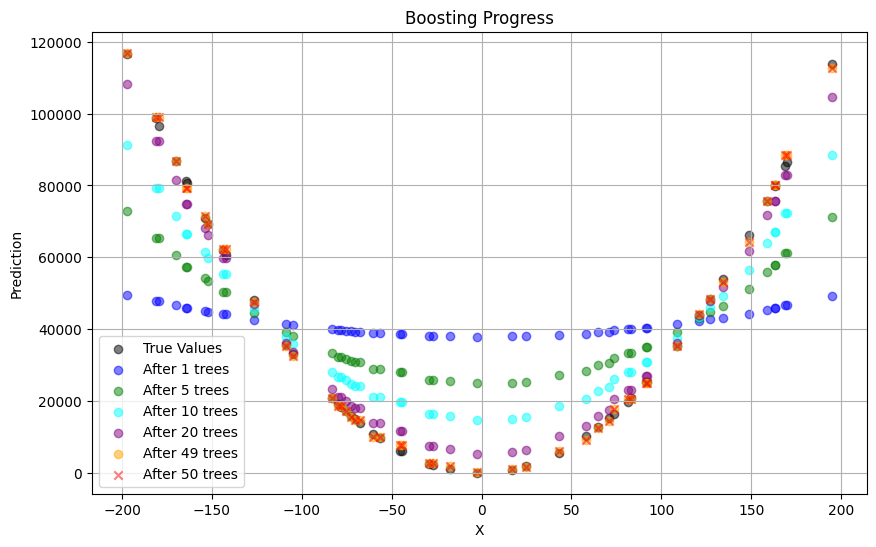

In [7]:
import matplotlib.pyplot as plt


# Plot true values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color="black", label="True Values", alpha=0.5)

# Scatter plot of predictions after every 20th tree
colors = ["blue", "green", "aqua", "purple", "orange"]
col = 0
T = xgboost_example.n_estimators
for i in [1, 5, 10, 20, T-1]:
    y_pred = xgboost_example.predict(
        X_test, n_trees=i)
    plt.scatter(X_test, y_pred,
                color=colors[col], label=f"After {i} trees", alpha=0.5)
    col += 1
# Scatter plot of final prediction
plt.scatter(X_test, y_pred, color="red",
            label=f"After {T} trees",
            marker="x", alpha=0.5)
plt.title("Boosting Progress")
plt.xlabel("X")
plt.ylabel("Prediction")
plt.legend()
plt.grid(True)
plt.show()

## GradientBoostingRegressor

We can implement an equivalent `GradientBoostingRegressor()` as follows. The `learning_rate=.1`.

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=10,
    n_estimators=50,
    learning_rate=.1,
    random_state=42)
gbrt.fit(X_train, y_train.reshape(-1))
y_pred = gbrt.predict(X_test)

In [9]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:,.2f}, MAE: {mae:,.2f}")

MSE: 959,933.30, MAE: 688.83


## XGBoost

Is a different python library that tunes to be scalable, fast and portable. 